In [64]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# matplotlib 설정
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """transition 저장"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [73]:
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100개의 에피소드 평균을 가져 와서 도표 그리기
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 도표가 업데이트되도록 잠시 멈춤
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

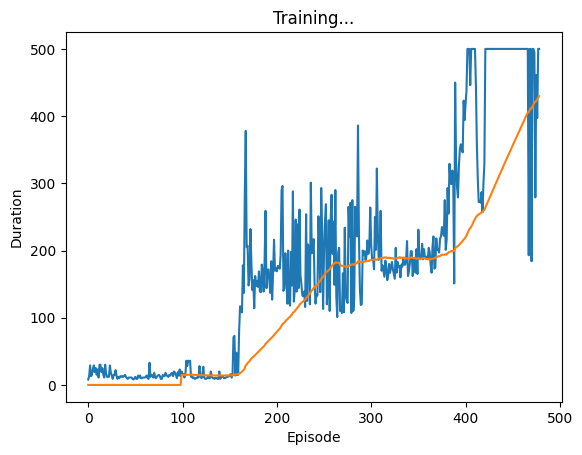

<Figure size 640x480 with 0 Axes>

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple, deque
import torch.nn.functional as F


from collections import namedtuple, deque
import random
import itertools

episode_durations = []

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # deque는 양방향 queue를 의미한다.
        self.memory = deque([], maxlen=capacity)
        self.recent_point = 0
        self.max_capacity = capacity


    def push(self, *args):
        # Transition을 저장하는 부분이다.
        self.memory.append(Transition(*args))


    def sample(self, batch_size=32):
        # memory로부터 batch_size 길이 만큼의 list를 반환한다.
        return random.sample(self.memory, batch_size)

    def __len__(self):
        # memory의 길이를 반환한다.
        return len(self.memory)


class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # 최적화 중에 다음 행동을 결정하기 위해서 하나의 요소 또는 배치를 이용해 호촐됩니다.
    # ([[left0exp,right0exp]...]) 를 반환합니다.
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class DQN_Agent(nn.Module):
    def __init__(self, num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        super(DQN_Agent, self).__init__()

        self.policy_net = DQN(num_states, num_actions)
        self.target_net = DQN(num_states, num_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.gamma = 0.99
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.0001, amsgrad=False)

        self.tau = 1.
        self.tau_decay = .99999
        self.tau_min = 0.01

        self.epsilon = 1.
        self.epsilon_decay = .999
        self.epsilon_min = 0.01

        self.Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


        self.train() # 훈련 모드 설정



    def act(self, state, steps_done):
        EPS_START = 0.9
        EPS_END = 0.05
        EPS_DECAY = 1000

        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1


        if np.random.rand() < eps_threshold:
            action = np.random.choice(self.num_actions)
        else:
            with torch.no_grad():
                q_values = self.policy_net(state)
                action = torch.argmax(q_values).item()
        return action, steps_done




    def optimize(self, replay_memory, batch_size=32):
        if len(replay_memory) < batch_size:
            return

        self.optimizer.zero_grad()

        batch = replay_memory.sample(batch_size)

        batch = self.Transition(*zip(*batch))



        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action).unsqueeze(-1)
        reward_batch = torch.cat(batch.reward)



        q_values = self.policy_net(state_batch).gather(1, action_batch)

        next_action = torch.zeros(batch_size, dtype=torch.long)
        double_q_value = torch.zeros(batch_size)

        with torch.no_grad():
            next_action[non_final_mask] = self.policy_net(non_final_next_states).max(1)[1]
            double_q_value[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]


        # 기대 Q 값 계산
        target_q_values = (double_q_value * self.gamma) + reward_batch

        criterion = nn.SmoothL1Loss()
        loss = criterion(q_values, target_q_values.unsqueeze(1))

        loss.backward()                 # 역전파
        self.optimizer.step()           # 경사 하강, 가중치를 업데이트
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)


        return loss



def main(batch_size=32):
    TAU = 0.005

    env = gym.make('CartPole-v1')
    dqn_agent = DQN_Agent(4,2)    # SARSA를 위한 행동-가치 함수


    max_capacity = 10000

    # ('state', 'action', 'next_state', 'reward', 'done')
    replay = ReplayMemory(max_capacity)

    MAX_STEP = 500

    total_reward = 0
    step_done = 0
    for step in range(MAX_STEP):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        total_reward = 0
        for t in count():
            action, step_done = dqn_agent.act(state, step_done)

            observation, reward, done, truncated = env.step(action)
            observation, reward, done =  torch.tensor(observation, dtype=torch.float32).unsqueeze(0),\
                                        torch.tensor(reward, dtype=torch.float32).unsqueeze(0),\
                                        torch.tensor(done, dtype=torch.bool).unsqueeze(0)

            if done:
                next_state = None
            else:
                next_state = observation

            replay.push(state, torch.tensor(action).unsqueeze(0), next_state, reward, done)

            state = next_state

            loss = dqn_agent.optimize(replay, batch_size=128)

            target_net_state_dict = dqn_agent.target_net.state_dict()
            policy_net_state_dict = dqn_agent.policy_net.state_dict()

            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

            dqn_agent.target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                plot_durations()
                break



if __name__ == '__main__':
    main()
